# Simple Epidemic Simulator for Decision Motifs #

### Paul Cohen, 11/13/2022 ###

This notebook contains a simple, Mecha-style simulator for simulating epidemics.  It is not meant to be realistic. In fact, it's only purpose is to serve as the target simulator for Decision Motifs. It has no dependencies other than numpy, so anyone should be able to run it. 

In [1]:
import os
from types import MethodType
import numpy as np
from numpy.random import default_rng
rng = default_rng() # stuff for random sampling
import matplotlib.pyplot as plt

# used for assigning attribute values at random
def multinomial (n,probs):
        """
        If N is the desired sample size, then a multinomial distribution M that
        respects the K probabilities p_0...p_K-1 will have p_i * N instances of i.
        """
        m = len(probs)
        if m == 2:
            p = probs[0]
            return (rng.random(n) > p).astype(int)
        s = np.arange(len(probs))[::-1]
        a = np.empty((n),dtype=int)
        q=list((np.array(probs).cumsum()*n).astype(np.int32))[::-1]
        for i in range(m):
            a[:q[i]] = s[i] # fill a with the right number of each index from s
        np.random.shuffle(a)
        return a
    

## Define a World Class ##

I assume the world is a three-dimensional array in which rows represent agents, columns represent attributes, and the third dimension represents agents and their attribute at discrete time points.  

In [2]:
n_agents = 10000  # number of agents
n_sim_steps = 100 # number of simulation steps

class EpiWorld ():
    ''' World for SIR model'''
    def __init__(self,attributes,initial_conditions, n=n_agents, sim_steps=n_sim_steps):
        self.time=0
        self.n = n
        self.pop = np.ones(n).astype(bool)
        self.attributes = attributes
        self.attr2col = {a:c for c,a in enumerate(self.attributes)}
        self.sim_steps = sim_steps
        self.table = np.zeros((self.n,len(self.attributes),self.sim_steps))  
        self.initial_conditions = initial_conditions
        self.init_world() 
        
    def get_col (self,name,time=None):
        t = time or self.time
        return self.table[:,self.attr2col.get(name),t]
    
    def set_col (self,name,values,time=None,selected=None):
        t = time or self.time
        col = self.attr2col.get(name)
        selected_ = selected if selected is not None else self.pop          
        if type(values) in [list,np.ndarray]:
            self.table[:,col,t][selected_] = values[selected_]
        else:
            self.table[:,col,t][selected_] = np.full(self.n,values)[selected_]

    def init_world (self): 
        for attribute in self.initial_conditions:
            self.set_col(attribute[0],attribute[1](self),time=0)
    
    def cohort (self,attributes,values,time=None):
        t = time or self.time
        attributes_ = [self.attr2col[a] for a in attributes]
        return np.logical_and.reduce([self.table[:,col,t]==val for col,val in zip(attributes_,values)])
        
    def cohort_size (self,attributes,values,time=None): 
        t = time or self.time
        return np.sum(self.cohort(attributes,values,t))
    
    def add_func (self,function_name, function):
        setattr(self,function_name,MethodType(function,self))
    
    def reset (self):
        self.time = 0
        self.table[:,:,:] = 0
        self.init_world()

### Define a World Object ###

In [3]:
# this is a hack to make beta depend on age, so I define age first
age = multinomial(n_agents, [.2,.3,.35,.15])

epi = EpiWorld(
    n = n_agents,
    attributes = ['health','location','age','sex','beta','gamma','masked','mask_mandate'],
    initial_conditions = [
        # 5% of the population is infected initially
        ['health',lambda self: multinomial(self.n, [.95,.05])],
        # the population lives in regions 0,1,2 with probs .25,.25,.5
        ['location', lambda self: multinomial(self.n, [.25,.25,.5])],
        # the population has four age groups, 0,1,2,3, with the last being rare
        ['age', lambda self: age],
        # the population is evenly divided between two sexes
        ['sex', lambda self: multinomial(self.n, [.5,.5])],
        # the initial value of beta is .125 but older people have higher values
        ['beta', lambda self: .125 + age * .04]
          ]
    
         )

epi.reset()

# health of the first 100 agents; 0,1 mean susceptible, infectious, respectively
epi.get_col('health',0)[:100]  

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.])

In [4]:
epi.table.shape
epi.get_col('beta')

array([0.205, 0.165, 0.245, ..., 0.205, 0.245, 0.165])

## Define Functions on the World ##

These are functions that read the world and calculate values of interest.  One of these is the probability of transmission between an infectious and a susceptible agent.

In [5]:
def p_transmission (self,beta,time=None):
    time_ = self.time if time is None else time
    p_susceptible = self.cohort_size(['health'],[0],time_)/self.n
    p_infectious = self.cohort_size(['health'],[1],time_)/self.n
    # The probability that one meeting between two agents has one
    # infectious and one Susceptible is:
    p_one_potential_transmission = p_infectious * p_susceptible
    # Potential transmissions become actual transmissions with
    # probability beta:
    p_one_transmission = p_one_potential_transmission * beta
    # return both probability of transmission and its complement
    return p_one_transmission

# Make this function be a method of epi
epi.add_func('p_transmission',p_transmission)

# What is the current p_transmission in epi world?
epi.p_transmission(epi.get_col('beta'))

array([0.00929352, 0.00748015, 0.01110689, ..., 0.00929352, 0.01110689,
       0.00748015])

## Define Simulator and Rule Classes ##

The simulator runs rules.  Rules read the values of attributes and change these values. 

In [6]:
class Sim ():
    def __init__(self, world,sim_steps=n_sim_steps):
        self.world = world
        self.sim_steps = sim_steps
        self.attr2col = world.attr2col
        self.actions = [] # a queue of actions specified by rules
        self.rules = []   # a list of rules
        
    def with_prob (self,p):
        ''' Returns a boolean vector in which True has a probability of approximately p'''
        q = p(self) if callable(p) else p
        return rng.random(self.world.n) < q
        
    def reset (self,reset_rules_actions=False):
        ''' If reset_rule_actions then rules are deleted and must be recreated.'''
        self.world.reset()
        self.time=0
        if reset_rules_actions:
            self.rules = []
            self.actions=[]
            
    def execute_rules (self,*args,**kwds):
        ''' Executing rules does not mean their actions are executed, it means their
        actions are queued up for execution.  This prevents rules talking to each other
        within a single interation of the simulator.'''
        for rule in self.rules:
            _condition = rule.condition(self,*args,**kwds) if callable(rule.condition) else rule.condition 
            if _condition:
                self.actions.append(
                    (rule.cohort,rule.attribute,rule.value,rule.probability,rule.name)
                )
                    
    def execute_actions (self):
        ''' This executes queued actions. `cohort` may be a lambda, which ensures that
        the rows to which an action applies are determined at execution time. If `cohort` is
        not callable then it must be a boolean vector or True or False.'''
        for action in self.actions:
            cohort,attribute,value,prob,name = action[0],action[1],action[2],action[3],action[4]
            
            if callable(cohort):
                cohort_ = cohort(self)
            elif type(cohort) in [list,np.ndarray]:
                cohort_ = np.array(cohort)
            elif cohort in [True,False]:
                cohort_ = np.full(self.world.n,cohort)
            else:
                raise ValueError("Cohort must be callable, a boolean array, or True or False")
            
            col = self.attr2col.get(attribute)
            if col is None: raise ValueError("Attribute name doesn't return a column number")
                
            # further restrict cohort by probability (if specified)
            if prob is None:
                selected = cohort_
            else:
                selected = np.logical_and(cohort_,self.with_prob(prob))
            
            
            # figure out what `value` is
            if callable(value):
                value_ = value(self)
            elif type(value) in [list,np.ndarray]:
                value_ = value
            elif type(value) in [int,float,bool]:
                value_ = np.full(self.world.n,value)
            
            # set the selected values of the selected column
            self.world.table[:,col,self.world.time][selected] = value_[selected]
            
            #print(np.unique(self.world.get_col('health'),return_counts=True))
        
        #reset the list of actions to empty before the next iteration    
        self.actions=[]
        
    def run (self):
        for i in range(self.sim_steps-1):
            # at time t0, execute rules, which say which actions will happen at time t1
            # but don't advance time or execute the actions
            self.execute_rules()
            
            # now advance time
            self.world.time = self.world.time + 1
            
            # copy the world at t0 to the world at t1
            self.world.table[:,:,self.world.time] = self.world.table[:,:,self.world.time-1]
            
            # finally, change the world at t1
            self.execute_actions()
        
    def get_rule (self,name):
        ''' Returns a rule object identified by name '''
        for rule in self.rules:
            if rule.name==name:
                return rule
        
epi.reset() 
sim=Sim(epi)

In [7]:
class Rule ():
    ''' `condition` is a boolean vector or a single boolean value.  If a vector,
    the rule applies only to True rows, if a boolean value, it applies to all (or none) 
    of the rows.  The `attribute` is a single attribute that is changed, the `value` 
    is a value, or an array of values, or a lambda expression that when evaluated returns
    an array of new values for the attribute. A cohort is a subset of the rows. 
    If `probability` is not None then it is a probability or a lambda that evaluates
    to a probabiity.
    '''
    def __init__(self,sim, world, name, attribute, value, cohort=True,condition=True,probability=None):
        self.sim=sim,
        self.world=world
        self.name=name
        self.attribute = attribute
        self.value = value
        self.cohort=cohort
        self.condition = condition
        self.probability = probability
        sim.rules.append(self)   


### Define Rule Objects ###

A rule says which `sim` and `world` it belongs to.  It has `name`.  Its `attribute` is an attribute in the world and is identified by the attribute name.  Its `value` is the value to which it will set its attribute for 1) all the members of its `cohort`, 2) with a given `probability`, 3) if its condition is True.

In [8]:
sim.reset(reset_rules_actions=True)

gamma = .03

Rule(
    sim = sim,
    world = epi,
    name = 's2i',
    attribute = 'health', 
    value  = 1,
    condition = True,
    cohort = lambda self: self.world.cohort(['health'],[0]),
    probability = lambda self: self.world.p_transmission(self.world.get_col('beta'))
)

# # This rule makes infected people recover. It applies only to the cohort of 
# # infected people, and with a probability equal to gamma

Rule(
    sim = sim,
    world = epi,
    name = 'i2r',
    attribute = 'health', 
    value  = 2,
    condition = True,
    cohort = lambda self: self.world.cohort(['health'],[1]),
    probability = gamma
)

# This rule makes recovered people susceptible. 
p_r2s = .02

Rule(
    sim = sim,
    world = epi,
    name = 'r2s',
    attribute = 'health', 
    value  = 0,
    condition = True,
    cohort = lambda self: self.world.cohort(['health'],[2]),
    probability = p_r2s
)



# # This rule decreases beta at the specified time

Rule(
    sim = sim,
    world = epi,
    name = 'impose_mask_mandate',
    attribute = 'beta', 
    value  = .04,
    condition = lambda self: self.world.time == 30,
    cohort = True
)

# # This rule increases beta at the specified time

Rule(
    sim = sim,
    world = epi,
    name = 'lift_mask_mandate',
    attribute = 'beta', 
    value  = .2,
    condition = lambda self: self.world.time == 60,
    cohort = True
)

## Run the Simulator ##

Running the simulator builds a 3D array in which axis 0 represents agents, axis 1 represents atributes and axis 2 represents time.  Thus, after running the simulator we can ask for the time series of `health` for an agent.

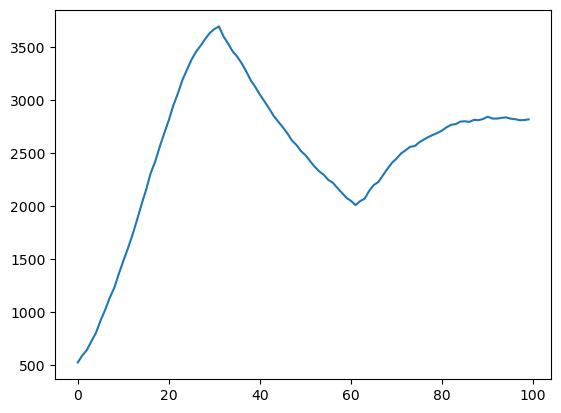

In [9]:
# resetting the sim resets the world and the simulator state, but keeps the rules.  
# To delete the rules (you'll need to redefine them) say sim.reset(reset_rules_actions=True)

sim.reset()

sim.run()

plt.plot(np.sum(epi.table[:,0,:] == 1,axis=0))

## Run the Simulator in Two Conditions ##

Here I will run the simulator in three conditions:

1) no intervention

2) mask mandate imposed on day 30

3) mask mandate imposed on day 30 and lifted on day 60

Having done this I will create an xarray of all three conditions and save it for Decision Queries analysis.

(4, 10000, 8, 100)

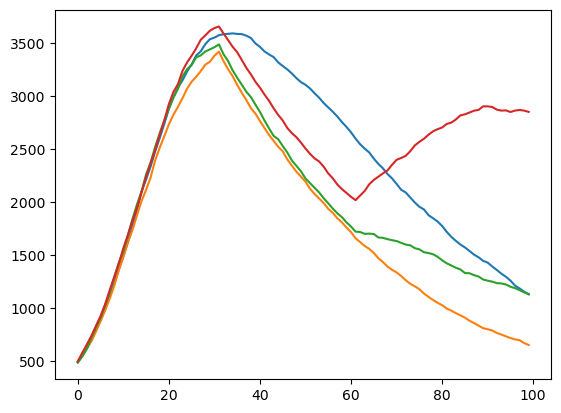

In [10]:
# Important:  You must make a copy of epi.table after each run

sim.reset()
sim.get_rule('impose_mask_mandate').condition = False
sim.get_rule('lift_mask_mandate').condition = False
sim.get_rule('r2s').condition = False
sim.run()
epi1=epi.table.copy()
plt.plot(np.sum(epi1[:,0,:] == 1,axis=0))



sim.reset()
sim.get_rule('impose_mask_mandate').condition = lambda self: self.world.time == 30
sim.get_rule('lift_mask_mandate').condition = False
sim.get_rule('r2s').condition = False
sim.run()
epi2=epi.table.copy()
plt.plot(np.sum(epi2[:,0,:] == 1,axis=0))



sim.reset()
sim.get_rule('impose_mask_mandate').condition = lambda self: self.world.time == 30
sim.get_rule('lift_mask_mandate').condition = lambda self: self.world.time == 60
sim.get_rule('r2s').condition = False
sim.run()
epi3=epi.table.copy()
plt.plot(np.sum(epi3[:,0,:] == 1,axis=0))


sim.reset()
sim.get_rule('impose_mask_mandate').condition = lambda self: self.world.time == 30
sim.get_rule('lift_mask_mandate').condition = lambda self: self.world.time == 60
sim.get_rule('r2s').condition = True
sim.run()
epi4=epi.table.copy()
plt.plot(np.sum(epi4[:,0,:] == 1,axis=0))


all_conditions=np.stack([epi1,epi2,epi3,epi4])
all_conditions.shape

Now we create a 4d xarray with dimensions:

- dimension 0 is the experimental scenario

- dimension 1 is replicates (in this example, replicates are agents)

- dimension 2 is attributes

- dimension 3 is time


In [11]:
import xarray as xr

cond = [0,1,2]
repls = np.arange(epi.table.shape[0])
attrs = enumerate(['health','location','age','sex','beta','gamma','masked','mask_mandate'])
times = np.arange(epi.table.shape[2])

ds = xr.Dataset(
    data_vars = {d[1] : xr.DataArray(all_conditions[:,:,d[0],:],dims = ['scenarios','replicates','times']) 
                 for d in attrs}
)

Now let's make sure that the xarray contains the same information as the original numpy array:

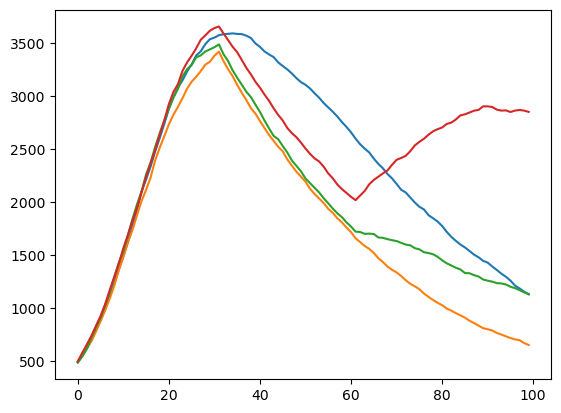

In [13]:
for condition in [0,1,2,3]:
    c = ds.isel(scenarios=[condition])
    plt.plot(np.sum(c.health==1,axis=1)[0])

In [14]:
# xr.to_netcdf doesn't overwrite as it is supposed to
if os.path.exists("../cube.netcdf"): 
    os.remove("../cube.netcdf")
else:
    pass

ds.to_netcdf("../cube.netcdf",mode="w")

ds_disk = xr.open_dataset("../cube.netcdf")
